In [2]:
import pdb, os, pickle,json 
import math 
import random
import pandas as pd
import numpy as np 
from scipy.stats import ttest_rel,ttest_ind, ttest_1samp 
from matplotlib import pyplot as plt 
import seaborn as snum_seeds 
from sklearn.metrics import adjusted_rand_score 
import requests
# humanUtils
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/humanUtils.py")
with open('humanUtils.py', 'w') as f:
    f.write(r.text)
from humanUtils import * 
# analysis
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/analysis.py")
with open('analysis.py', 'w') as f:
    f.write(r.text)
from analysis import *
# utils 
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/utils.py")
with open('utils.py', 'w') as f:
    f.write(r.text)
from utils import * 
%load_ext autoreload
%autoreload 2
snum_seeds.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22
condL = ['blocked','interleaved','early','middle','late']



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here are the parameters for you to toggle

In [3]:
sim_name = "my_sim"
schema_inference_off = True
concentration = 1.6
stickiness = 1.8
sparsity = 0.2
num_seeds = 50


Run the model here and save the data

In [4]:
model_acc_df_list = []
model_states_df_list = []
args = {'sem': {'beta2': 0, 'skipt1': schema_inference_off, 'ppd_allsch': 0}, 'sch': {'concentration': concentration, 'stickiness_wi': stickiness, 'stickiness_bt': stickiness, 'sparsity': sparsity, 'pvar': 0, 'lrate': 1, 'lratep': 1, 'decay_rate': 1}, 'exp': {'condition': None, 'n_train': 160, 'n_test': 40}}
exp_batch_data, concentrationValue_each_seed,_,_  = run_batch_exp_curr(num_seeds,args,condL)
# unpack and save
exp = np.stack([exp_batch_data[c][s]['exp'] for c in range(5) for s in range(num_seeds)]).reshape(5,num_seeds,200,5)
zt = np.stack([exp_batch_data[c][s]['zt'] for c in range(5) for s in range(num_seeds)]).reshape(5,num_seeds,200,5)
xth = np.stack([exp_batch_data[c][s]['xth'].argmax(-1) for c in range(5) for s in range(num_seeds)]).reshape(5,num_seeds,200,5)
acc = unpack_acc(exp_batch_data,mean_over_tsteps=True)
np.save(f'data/model/{sim_name}-acc',acc)
np.save(f'data/model/{sim_name}-exp',exp)
np.save(f'data/model/{sim_name}-zt',zt)
np.save(f'data/model/{sim_name}-xth' ,xth)
np.save(f'data/model/{sim_name}-alpha' ,np.array(concentrationValue_each_seed))
# for each of the condition types (blocked, interleaved, early, middle, late)
for cix in range(5):
    # for each seed
    for six in range(num_seeds):
      # and trial number
      for trix in range(200):
        # just mark it -1000 (this avoids pandas issues later on)
        a = -1000
        model_acc_df_list.append({
          'gs':sim_name,
          'alpha':a, # concentration value
          'cond':cix, # condition
          'seed':six, # seed
          'trial':trix, # trial
          'acc':acc[cix,six,trix] # get accuracy for this conditon, seed, trial
                                # unpack_acc function averages over tstep in trial
        })
        for tstep in range(5):
          model_states_df_list.append({
          'gs':sim_name,
          'alpha':a,
          'cond':cix,
          'seed':six,
          'trial':trix,
          'tstep':tstep,
          'exp':exp[cix,six,trix,tstep],
          'zt':zt[cix,six,trix,tstep],
          'xth':xth[cix,six,trix,tstep]
          })
model_acc_df = pd.DataFrame(model_acc_df_list)
model_states_df = pd.DataFrame(model_states_df_list)
# make a test column
model_acc_df.loc[:,'test'] = model_acc_df.trial >= 160
model_acc_df.loc[:,'cond_int'] = model_acc_df.cond
model_states_df.loc[:,'cond_int'] = model_states_df.cond
model_acc_df.cond = model_acc_df.cond.apply(lambda x: {
  0:'blocked',1:'interleaved',2:'early',3:'middle',4:'late'
}[x])

plot results from the above run of your custom simulation

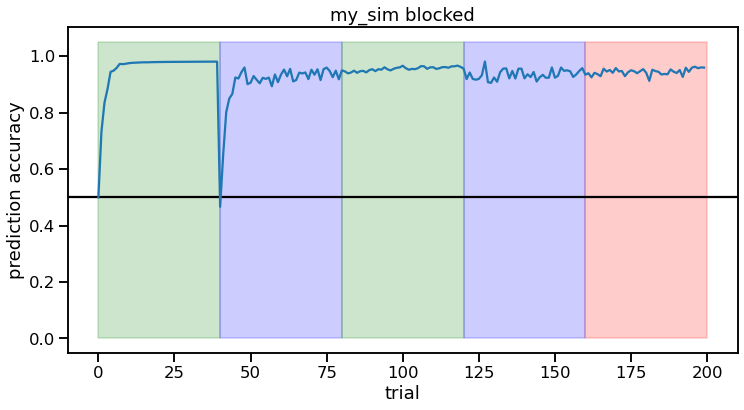

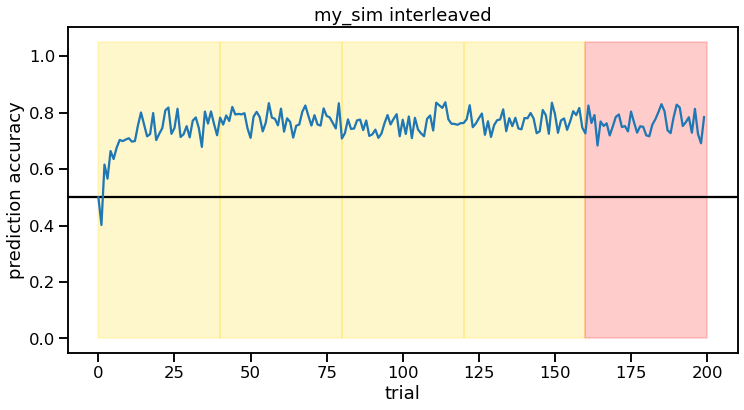

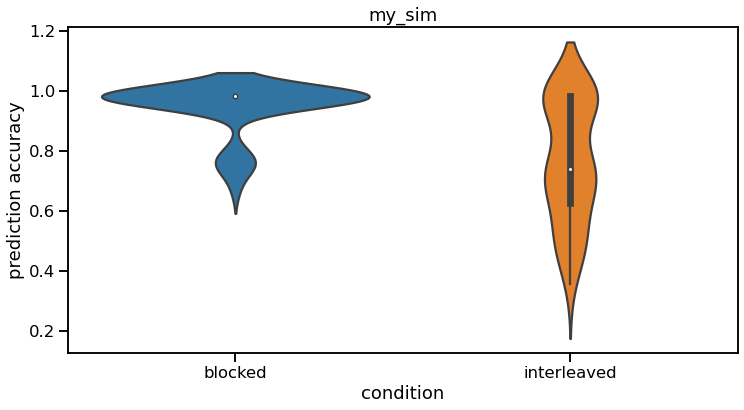

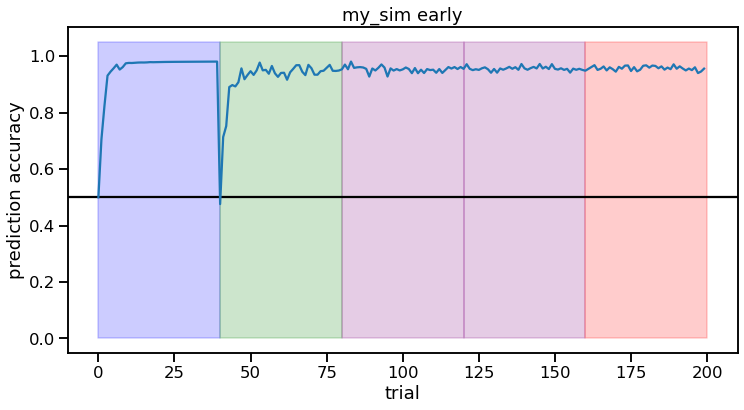

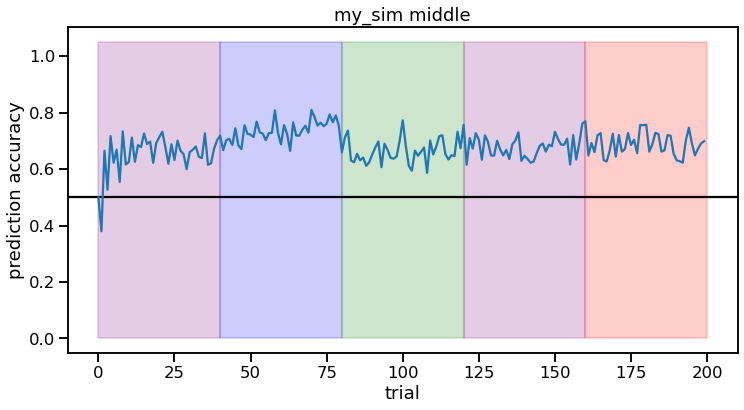

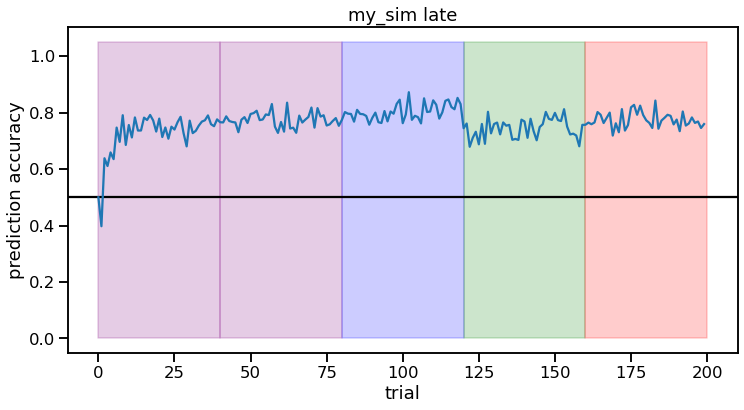

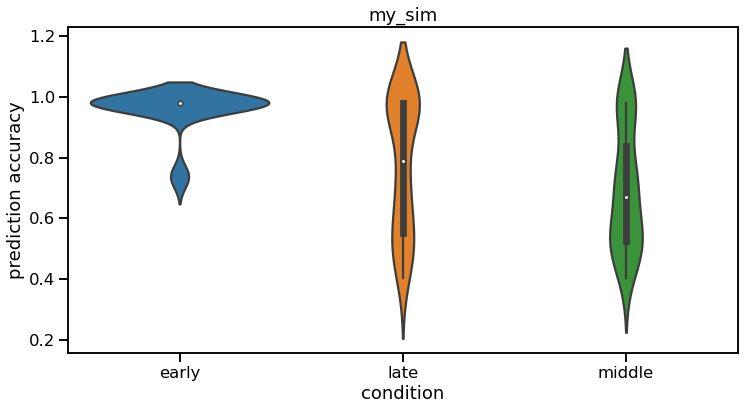

In [5]:
cLD = {
  'blocked': ['green','blue', 'green','blue', 'red'],
  'blocked_rep': ['green','blue', 'green','blue', 'red'],
  'interleaved': ['gold','gold','gold','gold','red'],
  'interleaved_rep': ['gold','gold','gold','gold','red'],
  'inserted_early': ['blue','green','purple','purple','red'],
  'early': ['blue','green','purple','purple','red'],
  'inserted_early_rep': ['blue','green','purple','purple','red'],
  'inserted_middle': ['purple','blue','green','purple','red'],
  'middle': ['purple','blue','green','purple','red'],
  'inserted_middle_rep': ['purple','blue','green','purple','red'],
  'inserted_late': ['purple','purple','blue','green','red'],
  'late': ['purple','purple','blue','green','red'],
  'inserted_late_rep': ['purple','purple','blue','green','red'],
  'explicit_interleaved': ['purple','purple','purple','purple','red'],
}

TITLES_ON = False
condL = ['blocked','interleaved','early','middle','late']

def color_background(ax,cond):
  for idx in range(5):
      ax.fill_between(
        np.arange(40*idx,41+40*idx),
        0,1.05,
        color=cLD[cond][idx],
        alpha=0.2
    )

def lineplot_model(sim_name,condstr,cond_index,ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  ax.axhline(0.5,c='k')
  sns.lineplot(
    data=model_acc_df.query(f"gs=='{sim_name}'&{condstr}"
                  ).groupby(['trial','cond']).mean().reset_index(),
    x='trial',y='acc',hue='cond',ax=ax
  )
  ax.set_ylabel('prediction accuracy')  
  ax.legend().remove()
  ax.set_title(sim_name+" " + condL[cond_index])
  return ax
  
def lineplot_modelBI(sim_name,ax=None):
  for ix in [0,1]:
    ax=lineplot_model(sim_name,condstr=f'cond_int=={ix}' , cond_index = ix,ax=None)
    color_background(ax,['blocked','interleaved'][ix])

def lineplot_modelEML(sim_name):
  for ix in [2,3,4]:
    ax=lineplot_model(sim_name,condstr=f'cond_int=={ix}', cond_index = ix, ax=None)
    color_background(ax,['early','middle','late'][ix-2])

def beeswarm_model(sim_name,condstr, ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  sns.violinplot(
    data=model_acc_df.query(f"gs=='{sim_name}'&test==True&{condstr}"
                  ).groupby(['seed','cond']).mean().reset_index(),
    x='cond',y='acc',ax=ax
  )
  ax.set_ylabel('prediction accuracy')
  ax.set_xlabel('condition')
  ax.set_title(sim_name)

def beeswarm_modelBI(sim_name):
  beeswarm_model(sim_name,condstr='cond_int<2')

def beeswarm_modelEML(sim_name):
  beeswarm_model(sim_name,condstr='cond_int>=2')


lineplot_modelBI(sim_name)
beeswarm_modelBI(sim_name)
lineplot_modelEML(sim_name)
beeswarm_modelEML(sim_name)